# **Segment Anything Model for Camouflaged Object Detection¶
Camouflaged Object Detection (COD) is a segmentation task applied on images where the object of interest is camouflaged against the background. This notebook tries to use Segment Anything Model (SAM) for COD task on COD10k dataset.**

In [1]:
import os
import cv2
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.nn.functional import threshold, normalize
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cpu


In [3]:
for dirpath, dirnames, filenames in os.walk('/kaggle/input/cod10k'):
    #print(f"{dirpath}: contains {len(dirnames)} directories")
    if len(dirnames)==0:
        print(f"{dirpath} --> {len(filenames)} images")
    else:
        pass#print(f"{dirpath} --> {len(dirnames)} directories: {dirnames}")

/kaggle/input/cod10k/COD10K-v2/Test/Images/Image --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Test/GT_Objects/GT_Object --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Train/Images/Image --> 6000 images
/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object --> 6000 images


In [4]:
for dirpath, dirnames, filenames in os.walk('/kaggle/input/cod10k'):
    #print(f"{dirpath}: contains {len(dirnames)} directories")
    if len(dirnames)==0:
        print(f"{dirpath} --> {len(filenames)} images")
    else:
        pass#print(f"{dirpath} --> {len(dirnames)} directories: {dirnames}")

/kaggle/input/cod10k/COD10K-v2/Test/Images/Image --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Test/GT_Objects/GT_Object --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Train/Images/Image --> 6000 images
/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object --> 6000 images


In [5]:
cod_path = Path("/kaggle/input/cod10k")
train_img_path = cod_path/"COD10K-v2/Train/Images/Image"
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
test_img_path = cod_path/"COD10K-v2/Test/Images/Image"
test_gt_path = cod_path/"COD10K-v2/Test/GT_Objects/GT_Object"

                                                               #The glob method is used to find files matching a specific pattern in a directory.
                                                               #In this case, it's used to find files with the following extensions:
                                                              #*.jpg: finds files with the .jpg extension (image files)
                                                              #*.png: finds files with the .png extension (ground truth files)
train_img_list = sorted(list(train_img_path.glob("*.jpg")))    
train_gt_list = sorted(list(train_gt_path.glob("*.png")))
test_img_list = sorted(list(test_img_path.glob("*.jpg")))
test_gt_list = sorted(list(test_gt_path.glob("*.png")))

Random index = 816, Image size_HxW = (900, 1195)


(-0.5, 1194.5, 899.5, -0.5)

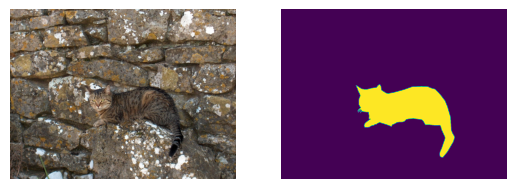

In [6]:
random_idx = random.randint(0,len(train_img_list))          # generates a random integer between 0 (inclusive) and the length of train_img_list (exclusive).This will be used to select a random image from the training dataset.
sample_img = train_img_list[random_idx]                     #selects the image at the random index from the train_img_list.
sample_gt = train_gt_list[random_idx]                       #selects the ground truth at the random index from the train_gt_list.
#sample_gt = train_gt_path/f"{sample_img.name[:len(sample_img.name)-3]}png"   #Alternative Way to Get Ground Truth
(sample_img, sample_gt)

img = Image.open(sample_img)   #opens the selected image using the Image module from PIL (Python Imaging Library).
gt = Image.open(sample_gt)     #opens the selected ground truth using the Image module from PIL.

print(f"Random index = {random_idx}, Image size_HxW = {tuple(reversed(img.size))}")

plt.subplot(1,2,1)                          # creates a subplot for the image.
plt.imshow(np.asarray(img))                 # displays the image. 
plt.axis(False)                             #hides the axis.
plt.subplot(1,2,2)                          #creates a subplot for the ground truth.
plt.imshow(np.asarray(gt))                  #displays the ground truth.
plt.axis(False)                             #hides the axis.

In [7]:

class CamouflageDataset(Dataset):
    def __init__(
        self,
        root_dir: str,                                                       #the root directory of the dataset
        image_transform: transforms.Compose,                                 #a PyTorch transform composition to apply to the images
        split: str                                                           #a string indicating whether to load the training ("train") or testing ("test") dataset
    ):
        self.root_dir=Path(root_dir)                                         # the root directory of the dataset as a Path object
        self.image_transform = image_transform                               #the PyTorch transform composition
        
        if split=="train":                                      
            self.data_dir = self.root_dir/"Train"                            #the directory containing the dataset split (either "Train" or "Test")
        elif split=="test":
            self.data_dir = self.root_dir/"Test"                 
        
        self.image_dir = self.data_dir/"Images/Image"                        #the directory containing the image files
        self.gt_dir = self.data_dir/"GT_Objects/GT_Object"                   # the directory containing the ground truth mask files
        
        self.unsorted_image_list = list(self.image_dir.glob("*.jpg"))        # lists of image and ground truth files, respectively, without sorting
        self.unsorted_gt_list = list(self.gt_dir.glob("*.png"))
        
        self.sorted_image_list = sorted(self.unsorted_image_list)            #sorted lists of image and ground truth files, respectively
        self.sorted_gt_list = sorted(self.unsorted_gt_list)
        
        #print(f"sorted_gt_list : { len(self.sorted_gt_list)}")
        #print(f"sorted_image_list : { len(self.sorted_image_list)}")

        #print(self.sorted_image_list[0:5])
        #print(self.sorted_gt_list[0:5])
        
        assert (len(self.sorted_image_list)==len(self.sorted_gt_list)), "Number of Images and Ground Truths are not same!"
    
    def __getitem__(self, idx):                                            #returns a single data sample from the dataset, given an index idx.
        img = Image.open(self.sorted_image_list[idx])                        
        gt = Image.open(self.sorted_gt_list[idx])                          # The dataset class loads and manages a dataset of images and ground truth masks.
                                                                           # It applies a PyTorch transform composition to the images and ground truth masks.
                                                                           # It ensures that the number of image files matches the number of ground truth files.
                                                                           # It provides a __getitem__ method to retrieve a single data sample and a __len__ method to return the total number of data samples.
        
        img = self.image_transform(img)
        gt = self.image_transform(gt)
        
        return img,gt
    
    def __len__(self):
        return len(self.sorted_image_list)


In [8]:
#The given code creates two instances of the CamouflageDataset class, one for the training dataset and one for the testing dataset.


image_transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])     # Creates a PyTorch transform composition using the Compose class from the transforms module.
                                                                                                # The composition consists of two transforms:
                                                                                                # transforms.Resize((512,512)): resizes the input images to a fixed size of 512x512 pixels.
                                                                                                # transforms.ToTensor(): converts the resized images to PyTorch tensors.
 
train_dataset = CamouflageDataset(                              # Creates an instance of the CamouflageDataset class for the training dataset.
    root_dir="/kaggle/input/cod10k/COD10K-v2",                  # specifies the root directory of the dataset.
    image_transform=image_transform,                            # applies the defined image transform to the training images.
    split="train"                                               # indicates that this instance should load the training dataset.
)

test_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    image_transform=image_transform,
    split="test"
)

In [9]:
train_dataloader=DataLoader(train_dataset,batch_size=4, shuffle=True)             #train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True):
                                                                                  #Creates a DataLoader object for the training dataset.
                                                                                  # Passes the following arguments to the constructor:
                                                                                  #train_dataset: the CamouflageDataset instance created earlier for the training dataset.
                                                                                  # batch_size=4: specifies the batch size for the training data. In this case, the DataLoader will return batches of 4 samples at a time.
                                                                                  # shuffle=True: enables shuffling of the training data. This is useful for training models, as it helps to reduce overfitting by randomizing the order of the samples.
test_dataloader=DataLoader(test_dataset,batch_size=4, shuffle=False)              # False here bcoz the order of the samples doesn't affect the evaluation of the model.

In [10]:
for dirpath, dirnames, filenames in os.walk("/kaggle/input/segment-anything"):
    print(dirnames)
    
    
# The for loop iterates over the directory tree, starting from the root directory "/kaggle/input/segment-anything".
# For each iteration, the loop assigns the values of the 3-tuple to the variables dirpath, dirnames, and filenames.
# The print(dirnames) statement prints the list of subdirectories (dirnames) found in the current directory (dirpath).

['pytorch']
['vit-h', 'vit-l', 'vit-b']
['1']
[]
['1']
[]
['1']
[]


In [11]:
sam_checkpoint_b = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
sam_checkpoint_l = "/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth"
sam_checkpoint_h = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
#model_type = "vit_b"
sam_b = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_b)
sam_l = sam_model_registry["vit_l"](checkpoint=sam_checkpoint_l)
sam_h = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_h)
sam_b.to(device)
sam_l.to(device)
sam_h.to(device)
pass
#summary(model=sam_b, col_names=['num_params','trainable'])
#summary(model=sam_l)
#summary(model=sam_h, col_names=['num_params','trainable'])

# **SAM with Bounding Box**

In [12]:
for dirpath, dirnames, filenames in os.walk("/kaggle/input/segment-anything"):
    print(dirnames)
    
    
# The for loop iterates over the directory tree, starting from the root directory "/kaggle/input/segment-anything".
# For each iteration, the loop assigns the values of the 3-tuple to the variables dirpath, dirnames, and filenames.
# The print(dirnames) statement prints the list of subdirectories (dirnames) found in the current directory (dirpath).

['pytorch']
['vit-h', 'vit-l', 'vit-b']
['1']
[]
['1']
[]
['1']
[]


In [13]:
sam_checkpoint_b = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
sam_checkpoint_l = "/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth"
sam_checkpoint_h = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
#model_type = "vit_b"
sam_b = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_b)
sam_l = sam_model_registry["vit_l"](checkpoint=sam_checkpoint_l)
sam_h = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_h)
sam_b.to(device)
sam_l.to(device)
sam_h.to(device)
pass
#summary(model=sam_b, col_names=['num_params','trainable'])
#summary(model=sam_l)
#summary(model=sam_h, col_names=['num_params','trainable'])

**Co-ordinates of BOX**

In [14]:
bbox_prompt = torch.tensor([                         #dimension of the box ie start from Xmin,Ymin to Xmax,Ymax
    [0,0,900,900]
])
bbox_prompt = bbox_prompt.numpy()                     #converting this tensor to numpy

In [15]:
# Set up the SAM model with the encoded image

img_np = np.asarray(img.convert("RGB"))

#mask_predictor_b = SamPredictor(sam_model=sam_b)
#mask_predictor_l = SamPredictor(sam_model=sam_l)
mask_predictor_h = SamPredictor(sam_model=sam_h)
#mask_predictor_b.set_image(img_np)
#mask_predictor_l.set_image(img_np)
mask_predictor_h.set_image(img_np)

'''
# Predict mask with bounding box prompt for b
masks, scores, logits = mask_predictor_b.predict(
box=bbox_prompt,
multimask_output=False
)
# Predict mask with bounding box prompt for l

masks, scores, logits = mask_predictor_l.predict(
box=bbox_prompt,
multimask_output=False
)
'''
# Predict mask with bounding box prompt for h

masks, scores, logits = mask_predictor_h.predict(       #In the context of the mask_predictor_h model, the masks output is a tensor that contains the predicted masks for the objects in the input image.
box=bbox_prompt,                                        #the score is a confidence value that indicates how likely it is that a particular object is present in the image. It is a single value between 0 and 1, where a higher value indicates a higher likelihood.
multimask_output=False                                  # the logits output is a tensor that contains the raw, unnormalized output values for the objects in the input image.
)



In [16]:
masks.shape

(1, 900, 1195)

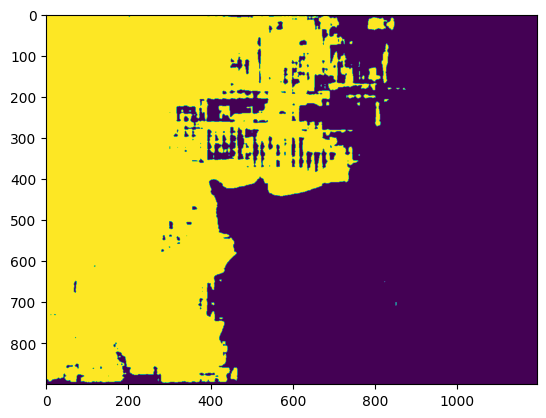

In [17]:
plt.imshow(masks[0])

**show_Box function code**

In [18]:
bbox_prompt

array([[  0,   0, 900, 900]])

So now we know bbox_prompt is an arry of 2d so we need for loop to iterate.

In [19]:
def show_box(bbox, ax):
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red')
    ax.add_patch(rect)


In [20]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

to have black background

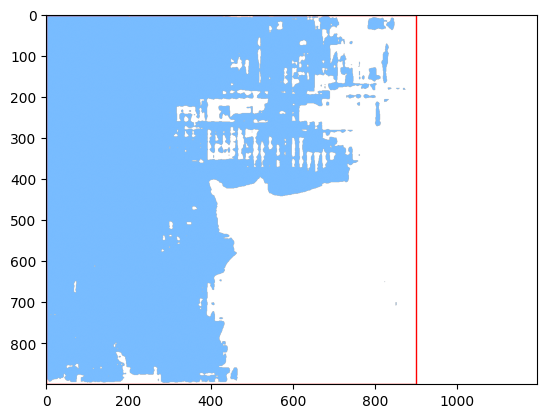

In [21]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')  # set figure background to black
ax.patch.set_facecolor('white')  # set axis background to black
##This upper code was to set manually background coloue to black.
show_mask(masks[0], plt.gca())
show_box(bbox_prompt.squeeze(), plt.gca())
plt.show()

(-0.5, 1194.5, 899.5, -0.5)

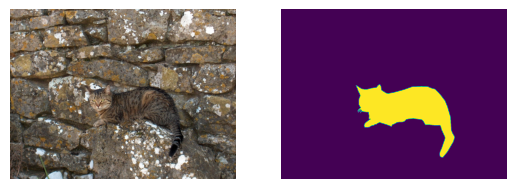

In [22]:
# Plotting the sample Image and Ground truth
plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)